In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

In [2]:
# Load preprocessed data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [3]:
# Define the original neural network model
def build_dnn_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# Define a Convolutional Neural Network (CNN) model
def build_cnn_model():
    model = keras.Sequential([
        keras.layers.Reshape(target_shape=(X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# Define a more complex Deep Neural Network (DNN) model
def build_complex_dnn_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Train and evaluate a model
def train_and_evaluate_model(model, model_name):
    print(f"\nTraining {model_name}...")
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype("int32")

    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    print(f"{model_name} - Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"{model_name} - ROC-AUC Score:")
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(roc_auc)

    return history, y_pred_proba, roc_auc

In [7]:
# Build, train, and evaluate each model
models = {
    "Original DNN": build_dnn_model(),
    "CNN": build_cnn_model(),
    "Complex DNN": build_complex_dnn_model()
}

predictions = {}
roc_aucs = {}

for model_name, model in models.items():
    history, y_pred_proba, roc_auc = train_and_evaluate_model(model, model_name)
    predictions[model_name] = y_pred_proba
    roc_aucs[model_name] = roc_auc


Training Original DNN...
Epoch 1/50
1400/1400 [==============================] - 13s 8ms/step - loss: 0.6511 - accuracy: 0.6276 - val_loss: 0.6048 - val_accuracy: 0.6833
Epoch 2/50
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6136 - accuracy: 0.6868 - val_loss: 0.5746 - val_accuracy: 0.7224
Epoch 3/50
1400/1400 [==============================] - 5s 4ms/step - loss: 0.5928 - accuracy: 0.7105 - val_loss: 0.5581 - val_accuracy: 0.7325
Epoch 4/50
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5798 - accuracy: 0.7189 - val_loss: 0.5514 - val_accuracy: 0.7357
Epoch 5/50
1400/1400 [==============================] - 4s 3ms/step - loss: 0.5733 - accuracy: 0.7235 - val_loss: 0.5488 - val_accuracy: 0.7328
Epoch 6/50
1400/1400 [==============================] - 5s 3ms/step - loss: 0.5679 - accuracy: 0.7232 - val_loss: 0.5467 - val_accuracy: 0.7339
Epoch 7/50
1400/1400 [==============================] - 3s 2ms/step - loss: 0.5665 - accuracy: 0.7241 - val_l

In [8]:
# Define pipelines for each model
pipelines = {
    'logistic': Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(max_iter=10000))
    ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('random_forest', RandomForestClassifier())
    ]),
    'gradient_boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('gradient_boosting', GradientBoostingClassifier())
    ])
}

In [9]:
# Define narrowed hyperparameters for GridSearch
param_grids = {
    'logistic': {
        'logistic__C': [0.1, 1, 10],
        'logistic__penalty': ['l2'],
        'logistic__solver': ['lbfgs']
    },
    'random_forest': {
        'random_forest__n_estimators': [50, 100],
        'random_forest__max_depth': [10, 20],
        'random_forest__min_samples_split': [5, 10]
    },
    'gradient_boosting': {
        'gradient_boosting__n_estimators': [50, 100],
        'gradient_boosting__learning_rate': [0.1, 0.2],
        'gradient_boosting__max_depth': [3, 5]
    }
}


In [10]:
def evaluate_model(grid_search, y_test, y_pred, y_pred_proba, model_name):
    # Best parameters
    print(f"\nBest Parameters for {model_name}:")
    print(grid_search.best_params_)

    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print(f"\nConfusion Matrix for {model_name}:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC-AUC score and ROC curve
    print(f"\nROC-AUC Score for {model_name}:")
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(roc_auc)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Save the best model
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, f'{model_name}_model_advanced.joblib')

    return roc_auc

Training and evaluating logistic model...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()



Best Parameters for logistic:
{'logistic__C': 10, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}

Classification Report for logistic:
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.73      6988
         1.0       0.75      0.68      0.71      7012

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000


Confusion Matrix for logistic:


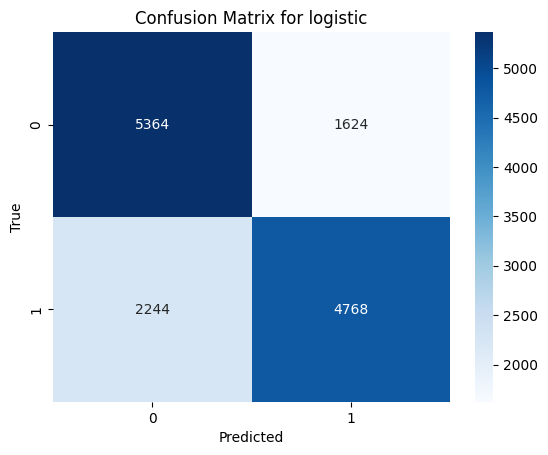


ROC-AUC Score for logistic:
0.7860770754101808


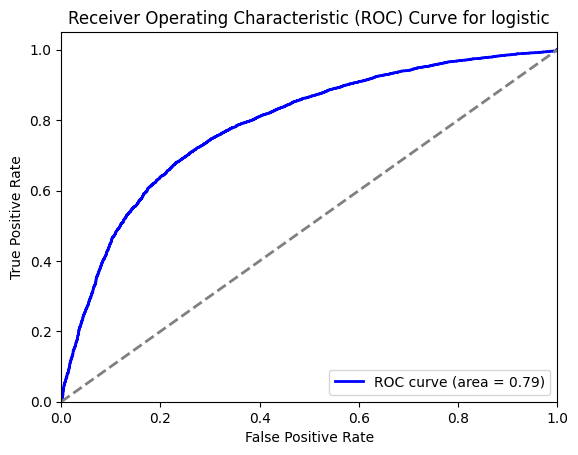

Training and evaluating random_forest model...

Best Parameters for random_forest:
{'random_forest__max_depth': 10, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 100}

Classification Report for random_forest:
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75      6988
         1.0       0.77      0.69      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000


Confusion Matrix for random_forest:


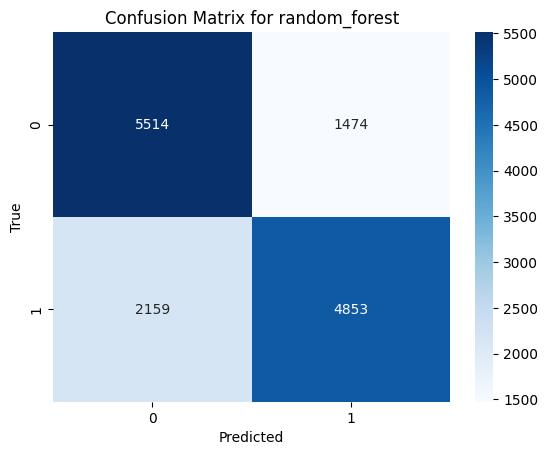


ROC-AUC Score for random_forest:
0.8022817965016061


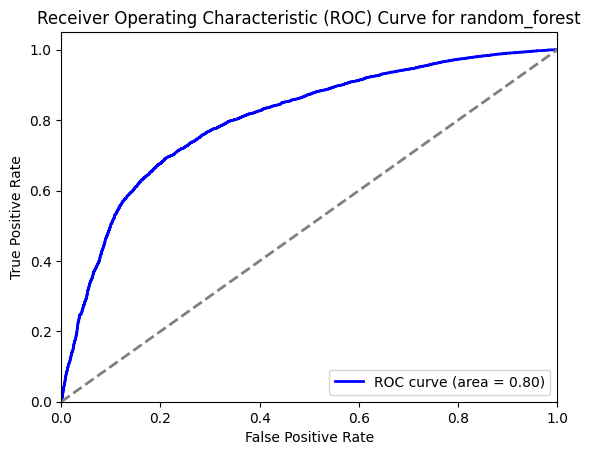

Training and evaluating gradient_boosting model...

Best Parameters for gradient_boosting:
{'gradient_boosting__learning_rate': 0.1, 'gradient_boosting__max_depth': 3, 'gradient_boosting__n_estimators': 100}

Classification Report for gradient_boosting:
              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74      6988
         1.0       0.75      0.71      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000


Confusion Matrix for gradient_boosting:


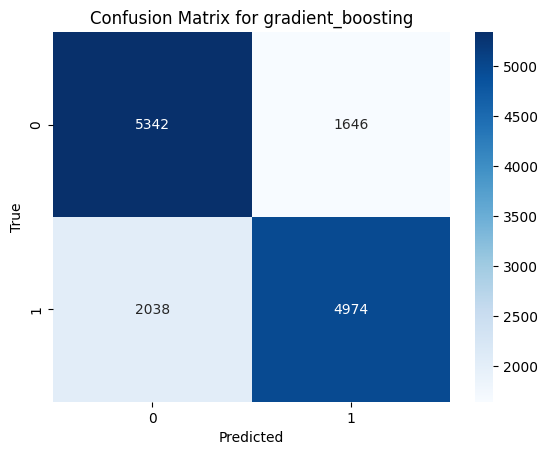


ROC-AUC Score for gradient_boosting:
0.8033608506931122


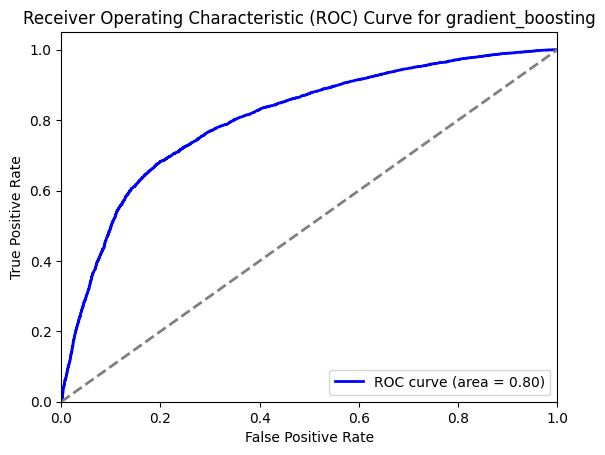

In [11]:
# Train and evaluate each traditional model
for model_name, pipeline in pipelines.items():
    print(f"Training and evaluating {model_name} model...")

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    roc_auc = evaluate_model(grid_search, y_test, y_pred, y_pred_proba, model_name)
    predictions[model_name] = y_pred_proba
    roc_aucs[model_name] = roc_auc

,Model,ROC-AUC Score
0,Original DNN,0.801182
1,CNN,0.798887
2,Complex DNN,0.799194
3,logistic,0.786077
4,random_forest,0.802282
5,gradient_boosting,0.803361


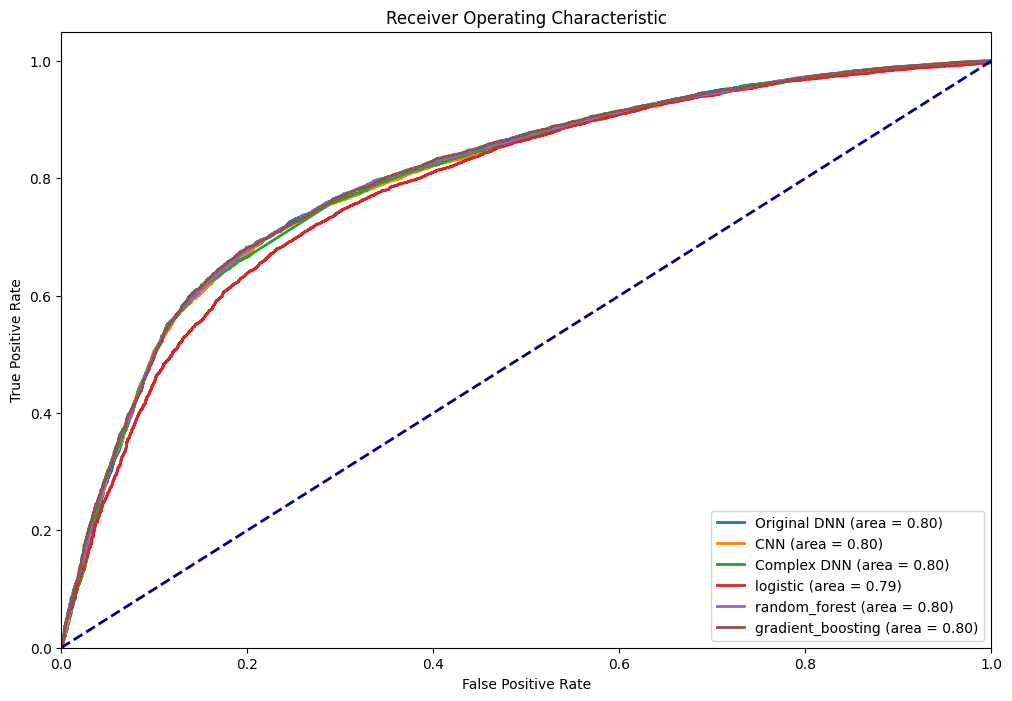

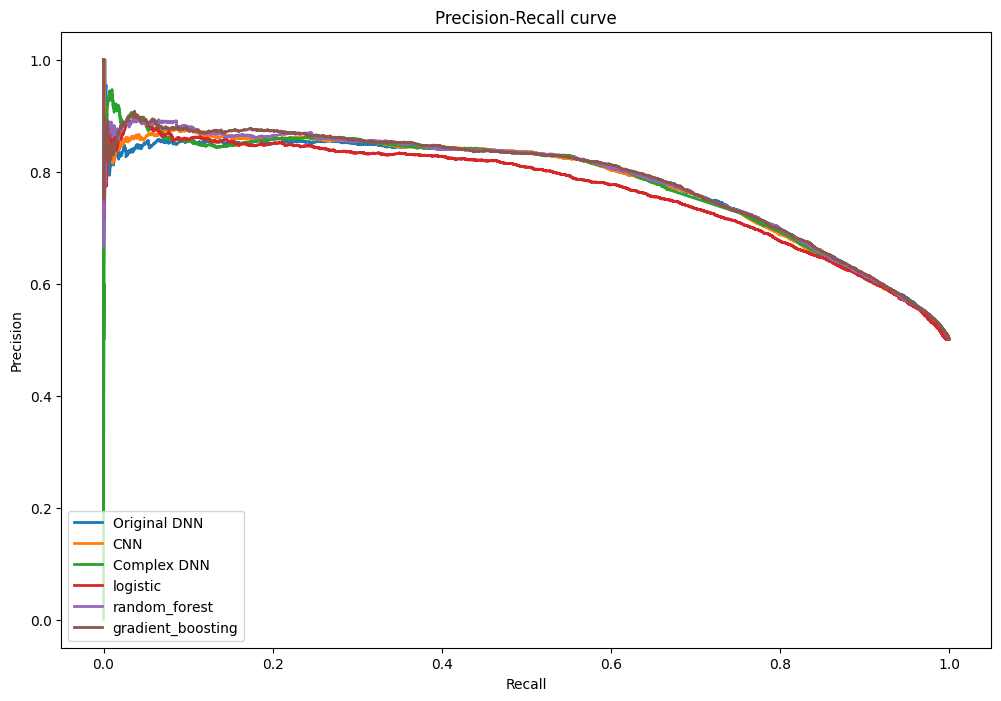

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Function to summarize results in a table
def summarize_results(results):
    summary = pd.DataFrame(results)
    display(summary)

# Collect metrics for all models
results = {
    'Model': [],
    'ROC-AUC Score': [],
}

# Combine ROC-AUC scores for all models
for model_name, roc_auc in roc_aucs.items():
    results['Model'].append(model_name)
    results['ROC-AUC Score'].append(roc_auc)

# Display results
summarize_results(results)

# Plot ROC curves for comparison
plt.figure(figsize=(12, 8))
for model_name, y_pred_proba in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curves for comparison
plt.figure(figsize=(12, 8))
for model_name, y_pred_proba in predictions.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, lw=2, label=f'{model_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()